# Отток клиентов. Постановка задачи, описание проекта.

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
3. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
4. Проведите финальное тестирование.

### Описание данных

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). Скачать датасет

**Признаки**

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**

Exited — факт ухода клиента

### 1. Загрузка и подготовка данных

In [27]:
# Импортируем нужные библиотеки

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

In [28]:
#Читаем данные из датасета
try:
    data = pd.read_csv('datasets/Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [29]:
#Смотрим на первые 10 строк
display(data.head(10))

#Узнаем общие сведения о данных
print(data.info())
print("Размер таблицы\n", data.shape)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
Размер таблицы
 (10000, 14)


In [30]:
# В данных есть пропустки в столбце Tenure. Заполним их значениями -1. Затем изменим тип данных на категориальный и применим прямое кодирование.
data['Tenure'] = data['Tenure'].fillna(-1)

#Приведем столбец к категориальному типу данных
data['Tenure'] = data['Tenure'].astype('category')

#Проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RowNumber        10000 non-null  int64   
 1   CustomerId       10000 non-null  int64   
 2   Surname          10000 non-null  object  
 3   CreditScore      10000 non-null  int64   
 4   Geography        10000 non-null  object  
 5   Gender           10000 non-null  object  
 6   Age              10000 non-null  int64   
 7   Tenure           10000 non-null  category
 8   Balance          10000 non-null  float64 
 9   NumOfProducts    10000 non-null  int64   
 10  HasCrCard        10000 non-null  int64   
 11  IsActiveMember   10000 non-null  int64   
 12  EstimatedSalary  10000 non-null  float64 
 13  Exited           10000 non-null  int64   
dtypes: category(1), float64(2), int64(8), object(3)
memory usage: 1.0+ MB


In [31]:
# Удалим столбец с порядковым номером и фамилией клиента. Они не нужны для исследования
data = data.drop('RowNumber', axis=1)
data = data.drop('Surname', axis=1)

In [32]:
# Применим прямое кодирование данных

data_ohe = pd.get_dummies(data, drop_first=True)

# Проверяем
display(data_ohe.head(3))

,CustomerId,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,...,Tenure_1.0,Tenure_2.0,Tenure_3.0,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0
0,15634602,619,42,0.00,1,1,1,101348.88,1,0,...,0,1,0,0,0,0,0,0,0,0
1,15647311,608,41,83807.86,1,0,1,112542.58,0,0,...,1,0,0,0,0,0,0,0,0,0
2,15619304,502,42,159660.80,3,1,0,113931.57,1,0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
# Делим выборку на тренировочные, валидационные и тестовые данные. Тестовые данные будем использовать в финальном тестировании.

target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)



features_train, features_valid_test, target_train, target_valid_test = train_test_split(
   features, target, test_size=0.4, random_state=42, stratify=target) # отделяем 40% данных для валидационно-тетсовой выборки, которая потом будет делится на валидационную и на тестовую. Используем стратификацию.

print("Размер валидационно-тестовой выборки", features_valid_test.shape)

features_valid, features_test, target_valid, target_test = train_test_split(
   features_valid_test, target_valid_test, test_size=0.5, random_state=42, stratify=target_valid_test) # делим пополам на валидационную и тестовую выборки.

# Проверяем размерность

print("\nРазмер тренировочной выборки", features_train.shape)
print("Размер валидационной выборки", features_valid.shape)
print("Размер тестовой выборки", features_test.shape)


Размер валидационно-тестовой выборки (4000, 22)

Размер тренировочной выборки (6000, 22)
Размер валидационной выборки (2000, 22)
Размер тестовой выборки (2000, 22)


### 2. Исследование баланса классов

In [34]:
# Стандартизация данных

numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
# Стандартизируем тестовую выборку
features_test[numeric] = scaler.transform(features_test[numeric])




/tmp/ipykernel_31/3212441093.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/3212441093.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [35]:
features_zeros = features_train[target_train == 0] 
features_ones = features_train[target_train == 1] 
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4778, 22)
(1222, 22)
(4778,)
(1222,)


**Вывод: Наблюдается дисбаланс классов, т.к. представителей класса 0 в 4 раза больше, чем класса 1. Потребуется upsampling.**

### Обучение модели без учета дисбаланса классов

In [36]:
# Обучим модель логистической регрессии

model = LogisticRegression(random_state=42, solver='liblinear', max_iter=100)
model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
predicted_valid = model.predict(features_valid) # Найдем предсказанные значения

print("F1:", f1_score(target_valid, predicted_valid)) # Посчитаем F1
# Интересненько. Поему-то 0. Посмотрим на зависимые метрики.
precision = precision_score(target_valid, predicted_valid) # Посчитаем точность
recall = recall_score(target_valid, predicted_valid)# Посчитаем полноту
print("Точность:", precision)
print("Полнота:", recall)
# По нулям. Теперь понятно, почему F1==0. Видимо модель предсказала одни нули. Проверим это.

unique, counts = np.unique(predicted_valid, return_counts=True) 
print("Уникальные значения в предсказании:", np.asarray((unique, counts)).T)
# Действительно, одни нули



probabilities_valid = model.predict_proba(features_valid) # Вычислим вероятности
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", auc_roc)

F1: 0.0
Точность: 0.0
Полнота: 0.0
Уникальные значения в предсказании: [[   0 2000]]


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC-ROC: 0.52241600157651


In [37]:
#Попробуем еще удалить столбец CustomerId и посмотрим как поведет себя модель на этот раз

features_train = features_train.drop('CustomerId', axis=1)
features_valid = features_valid.drop('CustomerId', axis=1)



model = LogisticRegression(random_state=42, solver='liblinear', max_iter=100)
model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
predicted_valid = model.predict(features_valid) # Найдем предсказанные значения

print("F1:", f1_score(target_valid, predicted_valid)) # Посчитаем F1
# Интересненько. Поему-то 0. Посмотрим на зависимые метрики.
precision = precision_score(target_valid, predicted_valid) # Посчитаем точность
recall = recall_score(target_valid, predicted_valid)# Посчитаем полноту
print("Точность:", precision)
print("Полнота:", recall)

F1: 0.3127272727272727
Точность: 0.6056338028169014
Полнота: 0.2107843137254902


**Уже лучше. Теперь F1 не равен нулю. Разнца есть, зачистим CustomerId в и в тестовой выборке**

In [38]:
features_test = features_test.drop('CustomerId', axis=1)

### 3. Улучшение качества модели. Обучение разных моделей. Выбор оптимальной модели

In [39]:
# Так как мы имеем дисбаланс классов, будем использовать технику upsampling

# Зачистим сначала оставшиеся хвосты CustomerId
features_zeros = features_zeros.drop('CustomerId', axis=1)
features_ones = features_ones.drop('CustomerId', axis=1)

# Определим, во-сколько раз примерно нужно умножить количество записей класса 1, чтобы выборка стала сбалансированной
repeat = round(features_zeros.shape[0] / features_ones.shape[0])

features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

# Перемешаем даные
features_upsampled = shuffle(features_upsampled, random_state=42)
target_upsampled = shuffle(target_upsampled, random_state=42)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9666, 21)
(9666,)


In [40]:
features_downsampled = features_zeros.sample(frac=1/repeat, random_state=42)
target_downsampled = target_zeros.sample(frac=1/repeat, random_state=42)
    
features_downsampled = pd.concat([features_downsampled] + [features_ones])
target_downsampled = pd.concat([target_downsampled] + [target_ones])
    
    
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=42)

#Размер выборки после уменьшения
print(features_downsampled.shape)
print(target_downsampled.shape)

(2416, 21)
(2416,)


### Модель логистической регрессии

In [41]:
# Балансировка изменением весов классов 

model = LogisticRegression(random_state=42, solver='liblinear', max_iter=100, class_weight='balanced')
model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)

F1: 0.5166240409207161
AUC-ROC: 0.7914295743422998


In [42]:
# Выборка сбалансирована техникой upsampling
model = LogisticRegression(random_state=42, solver='liblinear', max_iter=100)
model.fit(features_upsampled, target_upsampled) # обучаем модель на тренировочной выборке
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)

F1: 0.5177065767284993
AUC-ROC: 0.7914557468716129


In [43]:
# Выборка сбалансирована техникой downsampling

model = LogisticRegression(random_state=42, solver='liblinear', max_iter=100)
model.fit(features_downsampled, target_downsampled) # обучаем модель на тренировочной выборке
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)


F1: 0.5170975813177647
AUC-ROC: 0.7922871095674451


**Слабый результат. F1 вчего 0.52. Как видно, от применяемой техники балансировки результат несильно зависит**

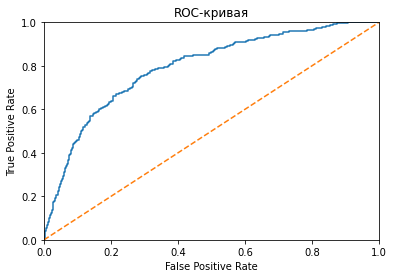

In [44]:
# Построим график ROC-кривой

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

# Устанавливаем границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Подписываем оси
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Добавляем заголовок
plt.title('ROC-кривая')
plt.show()

**AUC-ROC 0.79. Неплохо**

### Модель решающего дерева

In [45]:
%%time
# Для сбалансированной выборки методом upsample

best_model_tree = None
best_result = 0
for depth in range(1, 50):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth) # обучаем модель с заданной глубиной дерева
    model.fit(features_upsampled, target_upsampled) # обучаем модель
    predicted_valid = model.predict(features_valid) # получаем предсказания модели
    result_f1 = f1_score(target_valid, predicted_valid)

    if result_f1 > best_result:
        best_model_tree = model
        best_result = result_f1
        best_depth = depth
    print("max_depth =", depth, ": ", end='')
    print("F1:", result_f1)
        
print("F1 лучшей модели на валидационной выборке:", best_result, "Лучшая глубина:", best_depth)

probabilities_valid = best_model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)

max_depth = 1 : F1: 0.5170193192272309
max_depth = 2 : F1: 0.5387387387387388
max_depth = 3 : F1: 0.5578747628083491
max_depth = 4 : F1: 0.5427631578947368
max_depth = 5 : F1: 0.5726795096322242
max_depth = 6 : F1: 0.5749128919860628
max_depth = 7 : F1: 0.561492790500424
max_depth = 8 : F1: 0.5633546034639927
max_depth = 9 : F1: 0.5645472061657033
max_depth = 10 : F1: 0.5553359683794468
max_depth = 11 : F1: 0.5646817248459959
max_depth = 12 : F1: 0.5424083769633508
max_depth = 13 : F1: 0.5334773218142549
max_depth = 14 : F1: 0.5277161862527716
max_depth = 15 : F1: 0.5279069767441861
max_depth = 16 : F1: 0.5280373831775701
max_depth = 17 : F1: 0.5106888361045131
max_depth = 18 : F1: 0.525934861278649
max_depth = 19 : F1: 0.4993909866017052
max_depth = 20 : F1: 0.510948905109489
max_depth = 21 : F1: 0.5067650676506765
max_depth = 22 : F1: 0.5018450184501846
max_depth = 23 : F1: 0.49752475247524747
max_depth = 24 : F1: 0.49752475247524747
max_depth = 25 : F1: 0.49752475247524747
max_depth

In [46]:
%%time
# Для сбалансированной выборки методом downsample

best_model_tree = None
best_result = 0
for depth in range(1, 50):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth) # обучаем модель с заданной глубиной дерева
    model.fit(features_downsampled, target_downsampled) # обучаем модель
    predicted_valid = model.predict(features_valid) # получаем предсказания модели
    result_f1 = f1_score(target_valid, predicted_valid)

    if result_f1 > best_result:
        best_model_tree = model
        best_result = result_f1
        best_depth = depth
    print("max_depth =", depth, ": ", end='')
    print("F1:", result_f1)
        
print("F1 лучшей модели на валидационной выборке:", best_result, "Лучшая глубина:", best_depth)

probabilities_valid = best_model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)

max_depth = 1 : F1: 0.5088062622309197
max_depth = 2 : F1: 0.5334608030592736
max_depth = 3 : F1: 0.5334608030592736
max_depth = 4 : F1: 0.5484147386461011
max_depth = 5 : F1: 0.5783348254252462
max_depth = 6 : F1: 0.5804651162790698
max_depth = 7 : F1: 0.5810055865921787
max_depth = 8 : F1: 0.5605920444033303
max_depth = 9 : F1: 0.5555555555555556
max_depth = 10 : F1: 0.5334522747546834
max_depth = 11 : F1: 0.5154457193292145
max_depth = 12 : F1: 0.4925764192139737
max_depth = 13 : F1: 0.49870129870129876
max_depth = 14 : F1: 0.4910485933503836
max_depth = 15 : F1: 0.47128378378378377
max_depth = 16 : F1: 0.4760302775441548
max_depth = 17 : F1: 0.48046550290939316
max_depth = 18 : F1: 0.47049180327868845
max_depth = 19 : F1: 0.47906197654941374
max_depth = 20 : F1: 0.4878048780487806
max_depth = 21 : F1: 0.4878048780487806
max_depth = 22 : F1: 0.4878048780487806
max_depth = 23 : F1: 0.4878048780487806
max_depth = 24 : F1: 0.4878048780487806
max_depth = 25 : F1: 0.4878048780487806
max_

In [47]:
%%time
# Для сбалансированной выборки методом изменения весов классов

best_model_tree = None
best_result = 0
for depth in range(1, 50):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth, class_weight='balanced') # обучаем модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучаем модель
    predicted_valid = model.predict(features_valid) # получаем предсказания модели
    result_f1 = f1_score(target_valid, predicted_valid)

    if result_f1 > best_result:
        best_model_tree = model
        best_result = result_f1
        best_depth = depth
    print("max_depth =", depth, ": ", end='')
    print("F1:", result_f1)
        
print("F1 лучшей модели на валидационной выборке:", best_result, "Лучшая глубина:", best_depth)

probabilities_valid = best_model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)

max_depth = 1 : F1: 0.5170193192272309
max_depth = 2 : F1: 0.5387387387387388
max_depth = 3 : F1: 0.5578747628083491
max_depth = 4 : F1: 0.5427631578947368
max_depth = 5 : F1: 0.5726795096322242
max_depth = 6 : F1: 0.5754141238012207
max_depth = 7 : F1: 0.5624468988954971
max_depth = 8 : F1: 0.5648994515539305
max_depth = 9 : F1: 0.5606936416184972
max_depth = 10 : F1: 0.5571142284569138
max_depth = 11 : F1: 0.5670103092783505
max_depth = 12 : F1: 0.5406546990496304
max_depth = 13 : F1: 0.5353982300884956
max_depth = 14 : F1: 0.5358744394618834
max_depth = 15 : F1: 0.5249709639953541
max_depth = 16 : F1: 0.507142857142857
max_depth = 17 : F1: 0.5095693779904307
max_depth = 18 : F1: 0.510948905109489
max_depth = 19 : F1: 0.5067650676506765
max_depth = 20 : F1: 0.5195121951219512
max_depth = 21 : F1: 0.5080545229244113
max_depth = 22 : F1: 0.5031446540880503
max_depth = 23 : F1: 0.48994974874371855
max_depth = 24 : F1: 0.49122807017543857
max_depth = 25 : F1: 0.49122807017543857
max_dept

### Модель случайного леса

In [48]:
%%time
# Для сбалансированной выборки методом upsample

best_result = 0
best_model_forest = None

# Сначала найдем лучшую глубину, затем подберем лучшее количество деревьев. Глубину ограницем до 50.
for depth in range(1, 50):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=42)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid) # получаем предсказания модели
    result_f1 = f1_score(target_valid, predicted_valid)
    print(result_f1)
    if result_f1 > best_result:
        best_model_forest_first_upsampled = model # сохраняем наилучшую модель
        best_result = result_f1 #  сохраняем наилучшее значение метрики F1 на валидационных данных
        best_depth = depth

# Посчитаем лучшие F1 и глубину        
print("F1 наилучшей модели на валидационной выборке:", best_result, "\nЛучшая глубина:", best_depth)


probabilities_valid = best_model_forest_first_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)

0.5427046263345197
0.5806451612903226
0.5859375000000001
0.5861084681255947
0.5978367748279252
0.6097794822627037
0.5978578383641674
0.629327902240326
0.6275720164609054
0.6150583244962884
0.6318082788671024
0.6216814159292036
0.6166097838452788
0.6255813953488372
0.613744075829384
0.6213836477987421
0.6214549938347719
0.609452736318408
0.6042983565107459
0.5868725868725869
0.6103038309114928
0.5925925925925927
0.5866666666666666
0.6151761517615176
0.6133333333333333
0.5997322623828648
0.6040268456375839
0.5989010989010989
0.5951086956521738
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
0.5956284153005464
F1 наилучшей модели на валидационной выборке: 0.6318082788671024 
Лучшая

In [49]:
%%time
# Для сбалансированной выборки методом downsample

best_result = 0
best_model_forest = None

# Сначала найдем лучшую глубину, затем подберем лучшее количество деревьев. Глубину ограницем до 50.
for depth in range(1, 50):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=42)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid) # получаем предсказания модели
    result_f1 = f1_score(target_valid, predicted_valid)
    print(result_f1)
    if result_f1 > best_result:
        best_model_forest_first_downsampled = model # сохраняем наилучшую модель
        best_result = result_f1 #  сохраняем наилучшее значение метрики F1 на валидационных данных
        best_depth = depth

# Посчитаем лучшие F1 и глубину        
print("F1 наилучшей модели на валидационной выборке:", best_result, "\nЛучшая глубина:", best_depth)


probabilities_valid = best_model_forest_first_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)

0.5375118708452041
0.5816425120772947
0.5897435897435898
0.5918367346938774
0.5789954337899543
0.5939278937381405
0.5946969696969697
0.5711662075298439
0.5818847209515097
0.5813528336380256
0.5900452488687783
0.5854579792256844
0.5792850595783685
0.5577617328519856
0.5824884792626728
0.5532302092811647
0.5714285714285713
0.5674157303370787
0.5638686131386861
0.5757575757575758
0.5665399239543726
0.586437440305635
0.5768500948766603
0.5803402646502835
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
0.5810162991371045
F1 наилучшей модели на валидационной выборке: 0.5946969696969697 
Лучш

In [50]:
%%time
# Для сбалансированной выборки методом изменения весов классов

best_result = 0
best_model_forest = None

# Сначала найдем лучшую глубину, затем подберем лучшее количество деревьев. Глубину ограницем до 50.
for depth in range(1, 50):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=42, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid) # получаем предсказания модели
    result_f1 = f1_score(target_valid, predicted_valid)
    print(result_f1)
    if result_f1 > best_result:
        best_model_forest_first_class_weight = model # сохраняем наилучшую модель
        best_result = result_f1 #  сохраняем наилучшее значение метрики F1 на валидационных данных
        best_depth = depth

# Посчитаем лучшие F1 и глубину        
print("F1 наилучшей модели на валидационной выборке:", best_result, "\nЛучшая глубина:", best_depth)


probabilities_valid = best_model_forest_first_class_weight.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)

0.5374211000901713
0.5903846153846154
0.5888030888030888
0.5932367149758454
0.5971291866028707
0.6147704590818363
0.6150712830957231
0.6247379454926624
0.6155555555555555
0.6143646408839778
0.5959475566150179
0.6053921568627451
0.6051282051282052
0.5992115637319316
0.5790172642762285
0.571830985915493
0.5677233429394813
0.5778443113772455
0.5582089552238805
0.5598802395209581
0.5412844036697247
0.5671191553544496
0.5617283950617284
0.5731707317073171
0.5564142194744977
0.557632398753894
0.5593750000000001
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
0.5603715170278638
F1 наилучшей модели на валидационной выборке: 0.6247379454926624 
Лучша

**Результаты обучения на сбалансированной выборке методом upsamlpe лучшие. Лучшая глубина - 11. Эту выборку и метод балансировки применим далее**

In [51]:
%%time
best_model_forest = None
best_result = 0
criterion = ['gini', 'entropy'] # Проверим два критерия

# Выберем число деревьев 50
for est in range(1, 50):
    for crit_val in criterion:
        model = RandomForestClassifier(max_depth=11, random_state=42, n_estimators=est, criterion=crit_val) # обучаем модель с заданным количеством деревьев
        model.fit(features_upsampled, target_upsampled) # обучаем модель на тренировочной выборке
        #result = model.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
        #print("Accuracy:", result, "\nЧисло деревьев:", est, "\nКритерий:", crit_val)
        predicted_valid = model.predict(features_valid) # получаем предсказания модели
        result_f1 = f1_score(target_valid, predicted_valid)
        print(result_f1)
        if result_f1 > best_result:
            best_model_forest_second = model # сохраняем наилучшую модель
            best_result = result_f1 #  сохраняем наилучшее значение метрики accuracy на валидационных данных
            best_est = est
            best_crit_val = crit_val

# Посчитаем F1        
print("F1 наилучшей модели на валидационной выборке:", best_result, "\nЛучшее чсило деревьев:", best_est, "\nЛучший критерий:", best_crit_val)


probabilities_valid = best_model_forest_second.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)

0.530345471521942
0.5177111716621254
0.5212121212121211
0.5618199802176064
0.5761316872427984
0.5827552031714569
0.5764828303850157
0.5896414342629481
0.5874867444326617
0.6008230452674898
0.5878594249201279
0.5973223480947477
0.5955176093916755
0.5939771547248183
0.597457627118644
0.5900948366701791
0.6102783725910065
0.5987394957983193
0.6048034934497817
0.6012526096033404
0.6203904555314533
0.6078838174273858
0.6145494028230185
0.6137787056367432
0.6190476190476191
0.6150627615062761
0.6264800861141012
0.6115183246073299
0.6297502714440825
0.6174920969441516
0.6291390728476821
0.6220806794055203
0.6255411255411255
0.6188436830835118
0.6244541484716156
0.6165413533834586
0.6295081967213115
0.6237942122186495
0.6318082788671024
0.6135629709364907
0.6267682263329706
0.6172043010752688
0.6295081967213115
0.6264800861141012
0.6273224043715847
0.6180257510729613
0.632272228320527
0.6266094420600858
0.6297117516629711
0.6252676659528907
0.6320441988950276
0.6198704103671706
0.6301969365426

**Вывод: Лучший результат показала модель случайного леса на глубине 11, с числом деревьев 30, критерий gini. AUC-ROC: 0.86. Метод балансировки upsample. Эту модель и будем использовать в финальном тестировании.** 

### 4. Финальное тестирование модели

In [52]:
# По итогам работы моделей лушче других показала себя модель случайного леса. В нее и загрузим тестовые данные.

best_model_forest_predict = best_model_forest_second.predict(features_test)
result_f1 = f1_score(target_test, best_model_forest_predict)
print("Значение F1 для лучшей модели: ", result_f1)

probabilities_test = best_model_forest_second.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1] #  Предсказанные значения с объектами первого класса
auc_roc = roc_auc_score(target_test, probabilities_one_test) # Найдем значение AUC-ROC
print("AUC-ROC:", auc_roc)

Значение F1 для лучшей модели:  0.6077097505668934
AUC-ROC: 0.8545217019793291


**Вывод: Рассмотрев разные модели, пришли к выводу, что модель случайного леса наиболее хорошо предсказывает значения. Условие проекта выполнено, значение F1 > 59. Так же можно заметить, что метрика AUC-ROC колеблится в районе 80-85, что относительно хороший показатель. В конце проекта посмотрели как ведет себя модель на нестандартизированных данных (метрика F1 очень низкая). Это говорит о том, что размерность тренировочных, валидационных и тестовых данных должна быть одинаковой.
Код в проекте можно было сократить, однако порядок подготовки данных решено было оставить для демонстрации влияния лишних данных на качество модели.**